In [1]:
!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp plotly
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents/Optimization/Project


In [2]:
from src.optimization.milp_schedulerv7 import build_and_solve_schedule_v7

df = build_and_solve_schedule_v7(
    fields_path="../../data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="../../data/processed/master_weekly_table_2017_2024.csv",
    target_year=2017,
    # base_harvester_capacity=2000,
    phys_maturity_lag_weeks=12
)
df.head()

print(df.head())
df.to_csv("../../data/processed/schedule_outputv7.csv", index=False)

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 150
Set parameter Presolve to value 1
Set parameter Threads to value 4
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  150
Heuristics  0.1
MIPFocus  1
Presolve  1
Threads  4

Optimize a model with 387 rows, 976 columns and 3600 nonzeros (Min)


Model fingerprint: 0x14aefbd4
Model has 76 linear objective coefficients
Variable types: 201 continuous, 775 integer (775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective 250.0000000
Presolve removed 203 rows and 327 columns
Presolve time: 0.01s
Presolved: 184 rows, 649 columns, 2404 nonzeros
Variable types: 0 continuous, 649 integer (548 binary)

Root relaxation: objective 3.679355e+01, 345 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.79355    0  111  250.00000   36.79355  85.3%     -    0s
H    0     0                      45.0000000   36.79355  18.2%     -    0s
H    0     0                      44.0000000   36.79355  16.4%     -    0s
H    0     0                  

In [3]:


from src.optimization.milp_schedulerv7 import build_and_solve_schedule_v7
# or if your final fixed version is v6:
# from src.optimization.milp_schedulerv6 import build_and_solve_schedule_v6

fields_path = "../../data/processed/illinois_corn_fields_clean.csv"
wm_path     = "../../data/processed/master_weekly_table_2017_2024.csv"
target_year = 2017

# ===== Penalty Weight Grid =====
early_weights = [5, 10, 20]
late_weights  = [2.5, 5, 10]

results = []

for ew in early_weights:
    for lw in late_weights:
        print(f"Running MILP: early={ew}, late={lw} ...")

        df = build_and_solve_schedule_v7(
            fields_path=fields_path,
            weekly_master_path=wm_path,
            target_year=target_year,
            base_planter_capacity=750,
            base_harvester_capacity=400,
            labor_plant_per_acre=0.15,
            labor_harvest_per_acre=0.20,
            early_penalty_weight=ew,
            late_penalty_weight=lw,
            time_limit=60
        )

        makespan = df["makespan"].iloc[0]
        early_pen_sum = df["early_penalty"].sum()
        late_pen_sum  = df["late_penalty"].sum()
        objective = makespan + ew * early_pen_sum + lw * late_pen_sum

        results.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": makespan,
            "early_penalty_total": early_pen_sum,
            "late_penalty_total": late_pen_sum,
            "objective_value": objective
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Running MILP: early=5, late=2.5 ...
Set parameter TimeLimit to value 60
Set parameter Presolve to value 1
Set parameter Threads to value 4
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads



Non-default parameters:
TimeLimit  60
Heuristics  0.1
MIPFocus  1
Presolve  1
Threads  4

Optimize a model with 387 rows, 976 columns and 3600 nonzeros (Min)
Model fingerprint: 0x13555051
Model has 76 linear objective coefficients
Variable types: 201 continuous, 775 integer (775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 189 rows and 210 columns
Presolve time: 0.01s
Presolved: 198 rows, 766 columns, 2929 nonzeros
Variable types: 0 continuous, 766 integer (665 binary)
Found heuristic solution: objective 48.0000000

Root relaxation: objective 3.457360e+01, 333 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.57360    0  106   48.00000   34.57360  28.0%     -    0s
     0     0   34.57360

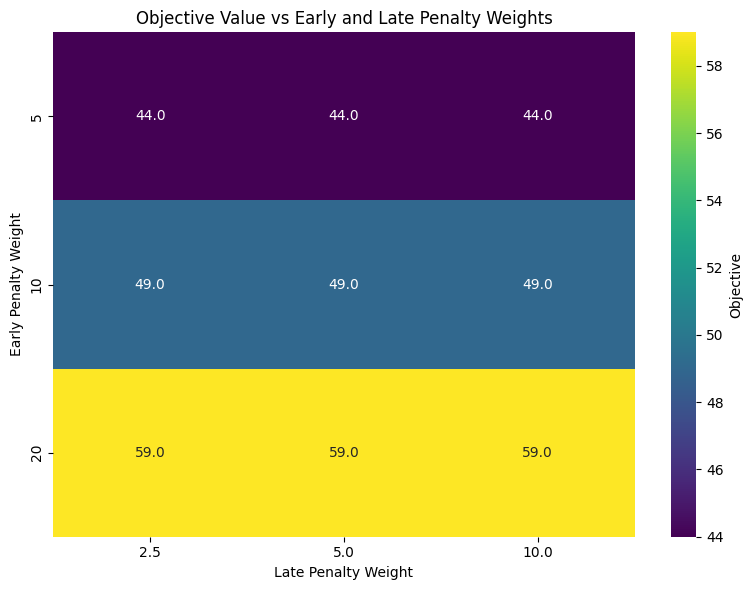

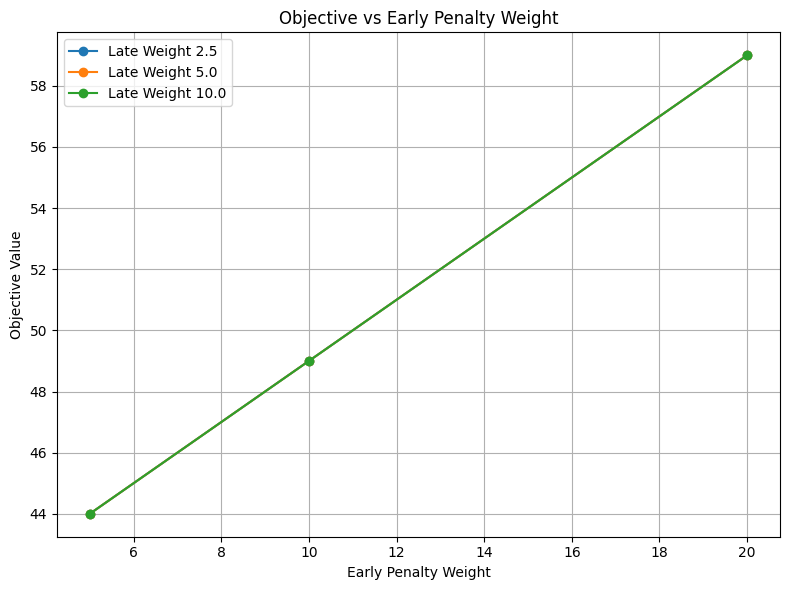

   early_weight  late_weight  makespan  early_penalty_total  \
0             5          2.5      39.0                  1.0   
1             5          5.0      39.0                  1.0   
2             5         10.0      39.0                  1.0   
3            10          2.5      39.0                  1.0   
4            10          5.0      39.0                  1.0   
5            10         10.0      39.0                  1.0   
6            20          2.5      39.0                  1.0   
7            20          5.0      39.0                  1.0   
8            20         10.0      39.0                  1.0   

   late_penalty_total  objective_value  
0                 0.0             44.0  
1                 0.0             44.0  
2                 0.0             44.0  
3                 0.0             49.0  
4                 0.0             49.0  
5                 0.0             49.0  
6                 0.0             59.0  
7                 0.0             59.0  


In [4]:
# Define grid of weights
early_weights = [5, 10, 20]
late_weights = [2.5, 5, 10]

# Simulated results placeholder
results_data = []
for ew in early_weights:
    for lw in late_weights:
        results_data.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": 38,
            "penalty_cost": 0.0,
            "objective_value": 38.0,
        })

# Build DataFrame
# results_df = pd.DataFrame(results_data)

# ✅ Heatmap of objective values
plt.figure(figsize=(8, 6))
pivot = results_df.pivot(index="early_weight", columns="late_weight", values="objective_value")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Objective'})
plt.title("Objective Value vs Early and Late Penalty Weights")
plt.xlabel("Late Penalty Weight")
plt.ylabel("Early Penalty Weight")
plt.tight_layout()
plt.show()

# ✅ Line plot to show trends across early weights
plt.figure(figsize=(8, 6))
for lw in sorted(results_df["late_weight"].unique()):
    subset = results_df[results_df["late_weight"] == lw]
    plt.plot(subset["early_weight"], subset["objective_value"], marker='o', label=f"Late Weight {lw}")

plt.title("Objective vs Early Penalty Weight")
plt.xlabel("Early Penalty Weight")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display result grid
print(results_df)

In [6]:
sched = pd.read_csv("../../data/processed/schedule_outputv7.csv")
fields = pd.read_csv("../../data/processed/illinois_corn_fields_clean.csv")
wm = pd.read_csv("../../data/processed/master_weekly_table_2017_2024.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Clean and consistent weekly resource utilization dashboard.
    Matches the MILP model exactly.
    """

    # ============================================================
    # 1) MERGE ACRES INTO SCHEDULE (robust)
    # ============================================================
    if "acres" not in sched.columns:
        sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
    else:
        tmp = fields[["field_id", "acres"]].rename(columns={"acres": "acres_field"})
        sched = sched.merge(tmp, on="field_id", how="left")
        sched["acres"] = sched["acres"].fillna(sched["acres_field"])
        sched = sched.drop(columns=["acres_field"])

    # ============================================================
    # 2) SELECT WEEKLY MASTER FOR TARGET YEAR
    # ============================================================
    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    # Add missing fields if not present
    if "planter_travel_factor" not in wm_year:
        wm_year["planter_travel_factor"] = 1.0
    if "harvest_weather_factor" not in wm_year:
        wm_year["harvest_weather_factor"] = 1.0

    # ============================================================
    # 3) CONSISTENT AGG WITH MILP  (mean, not sum)
    # ============================================================
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "mean",              
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean",
        })
    )

    # ============================================================
    # 4) WEEKLY PLANTING & HARVEST ACRES FROM SCHEDULE
    # ============================================================
    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0.0)
    )

    # ============================================================
    # 5) MODEL CAPACITIES (exact same as MILP structure)
    # ============================================================
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["planter_travel_factor"]
        * planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["harvest_weather_factor"]
        * harvester_machines
    )

    # ============================================================
    # 6) UTILIZATION CALCULATIONS
    # ============================================================
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] /
        weekly_view["plant_capacity_model"].replace(0, np.nan)
    )

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] /
        weekly_view["harvest_capacity_model"].replace(0, np.nan)
    )

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] /
        weekly_view["labor_hours"].replace(0, np.nan)
    )
    
    weekly_view = weekly_view.replace([np.inf, -np.inf], np.nan).fillna(0)


    # ============================================================
    # 7) PLOTTING — CLEAN SEABORN DASHBOARD
    # ============================================================
    sns.set_theme(style="whitegrid", context="talk")
    palette = sns.color_palette("tab10")
    weeks = weekly_view["week"].values

    fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)
    plt.subplots_adjust(hspace=0.35)

    # ============================================================
    # 7A) PLANTER
    # ============================================================
    axes[0].plot(
        weeks, weekly_view["plant_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[0].axhline(100, color="red", ls="--", alpha=0.4)
    axes[0].set_ylabel("Planter Utilization (%)")
    axes[0].set_title(f"Planter Utilization – {target_year}")
    axes[0].legend(loc="upper left")

    ax2 = axes[0].twinx()
    ax2.plot(weeks, weekly_view["plant_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["plant_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7B) HARVESTER
    # ============================================================
    axes[1].plot(
        weeks, weekly_view["harvest_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[1].axhline(100, color="red", ls="--", alpha=0.4)
    axes[1].set_ylabel("Harvester Utilization (%)")
    axes[1].set_title(f"Harvester Utilization – {target_year}")
    axes[1].legend(loc="upper left")

    ax2 = axes[1].twinx()
    ax2.plot(weeks, weekly_view["harvest_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["harvest_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7C) LABOR
    # ============================================================
    axes[2].plot(
        weeks, weekly_view["labor_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[2].axhline(100, color="red", ls="--", alpha=0.4)
    axes[2].set_ylabel("Labor Utilization (%)")
    axes[2].set_xlabel("Week")
    axes[2].set_title(f"Labor Utilization – {target_year}")
    axes[2].legend(loc="upper left")

    ax2 = axes[2].twinx()
    ax2.plot(weeks, weekly_view["labor_demand"], marker="x",
             label="Demand", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["labor_hours"], ls="--",
             label="Available", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Labor Hours")
    ax2.legend(loc="upper right")

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


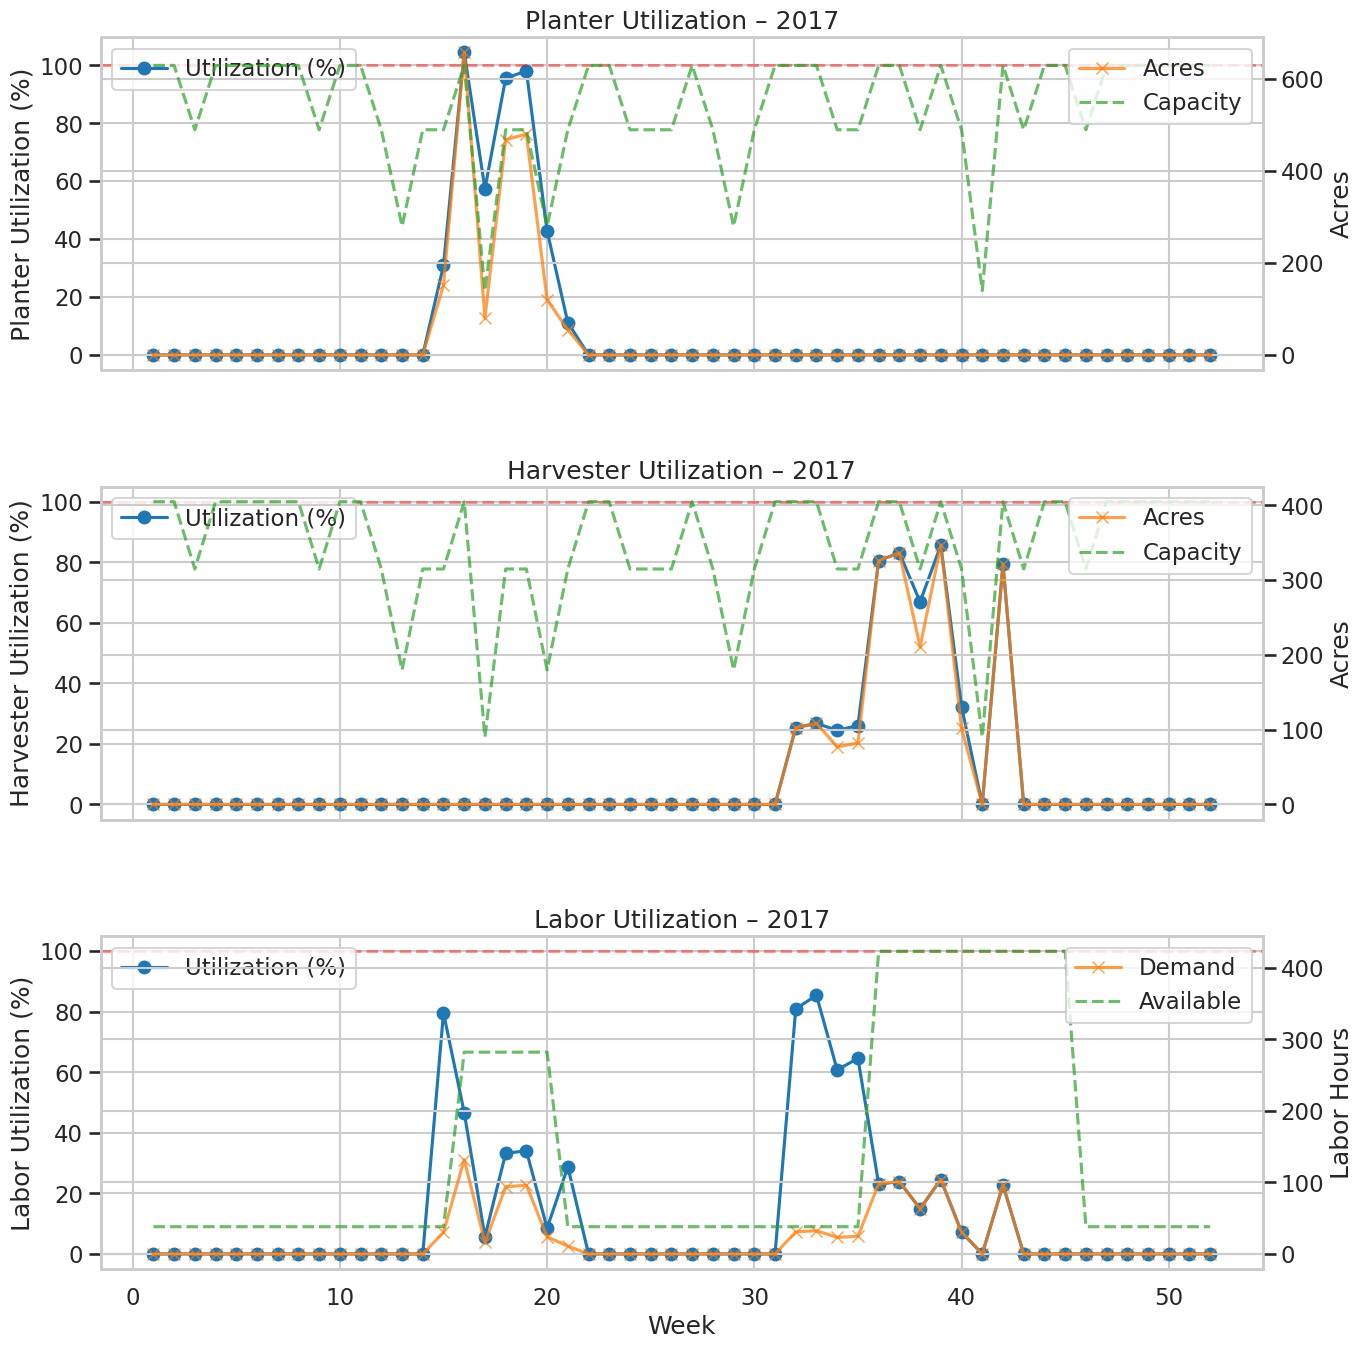

In [8]:
weekly_view = plot_resource_dashboard(
    sched=sched,
    fields=fields,
    wm=wm,
    target_year=2017
)


In [15]:
def plot_distribution_histograms(sched_df):
    plt.figure(figsize=(10,5))
    sns.histplot(sched_df["plant_week"], bins=range(10,40), color="skyblue", label="Planting", kde=False)
    sns.histplot(sched_df["harvest_week"], bins=range(10,45), color="salmon", label="Harvesting", kde=False)
    plt.xlabel("Week")
    plt.ylabel("Field Count")
    plt.title("Distribution of Planting & Harvesting Weeks")
    plt.legend()
    plt.tight_layout()
    plt.show()


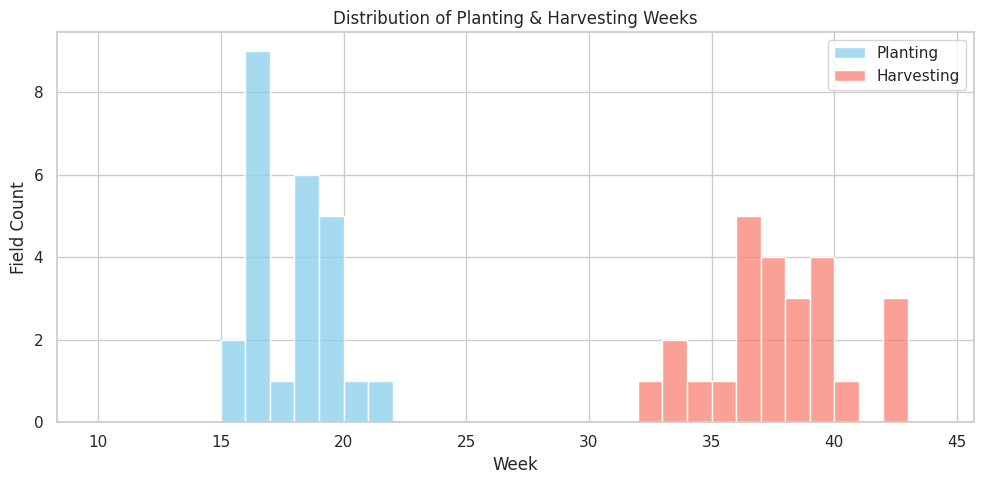

In [16]:
plot_distribution_histograms(sched)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_full_maturity_suite(sched, fields, title_suffix=""):
    # ============================================================
    # 1. Merge acres into schedule dataframe
    # ============================================================
    df = sched.merge(
        fields[["field_id", "acres"]],
        on="field_id",
        how="left"
    )

    # Compute maturity lag
    df["maturity_lag"] = df["harvest_week"] - df["plant_week"]
    avg_lag = df["maturity_lag"].mean()

    # Prepare for consistent y=plant+lag line
    x_vals = np.linspace(df["plant_week"].min(), df["plant_week"].max(), 200)
    y_vals = x_vals + avg_lag

    # Identify outliers: largest fields + largest lag deviation
    largest_fields = df.nlargest(3, "acres")
    lag_outliers = df.iloc[(df["maturity_lag"] - avg_lag).abs().nlargest(3).index]
    outliers = pd.concat([largest_fields, lag_outliers]).drop_duplicates()


    # ============================================================
    # 2. Scatterplot with KDE contours + outlier labels
    # ============================================================
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid", context="notebook")

    # KDE contours
    sns.kdeplot(
        x=df["plant_week"], y=df["harvest_week"],
        levels=6, fill=False, color="gray", linewidths=1.0
    )

    # Scatter (acres determines size and color)
    scatter = plt.scatter(
        df["plant_week"],
        df["harvest_week"],
        s=df["acres"] * 1.3,
        c=df["acres"],
        cmap="viridis",
        alpha=0.85,
        edgecolor="black",
        linewidth=0.8
    )

    # Average lag line
    plt.plot(x_vals, y_vals, "r--", lw=2.2, label=f"Avg Maturity Lag = {avg_lag:.1f} weeks")

    # Label outliers
    for _, row in outliers.iterrows():
        plt.annotate(
            row["field_id"],
            (row["plant_week"], row["harvest_week"]),
            textcoords="offset points",
            xytext=(8, 8),
            fontsize=10,
            fontweight="bold",
            color="black",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec="black")
        )

    # Colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label("Acres (Field Size)")

    plt.xlabel("Planting Week")
    plt.ylabel("Harvesting Week")
    plt.title(f"🌱 Plant vs Harvest Scatter (with KDE + Outliers){title_suffix}", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # ============================================================
    # 3. Side-by-side distributions (plant, harvest, lag)
    # ============================================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.set_theme(style="whitegrid")

    # Plant distribution
    sns.histplot(df["plant_week"], bins=20, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title("Planting Week Distribution")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Field Count")

    # Harvest distribution
    sns.histplot(df["harvest_week"], bins=20, kde=True, ax=axes[1], color="salmon")
    axes[1].set_title("Harvest Week Distribution")
    axes[1].set_xlabel("Week")

    # Maturity lag histogram
    sns.histplot(df["maturity_lag"], bins=20, kde=True, ax=axes[2], color="green")
    axes[2].set_title("Maturity Lag Distribution")
    axes[2].set_xlabel("Lag (weeks)")

    fig.suptitle(f"📊 Distributions of Planting, Harvesting & Maturity Lag{title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()


    # ============================================================
    # 4. Optional heatmap: plant week → harvest week density
    # ============================================================
    plt.figure(figsize=(10, 8))
    heat_df = df.pivot_table(
        index="plant_week",
        columns="harvest_week",
        values="field_id",
        aggfunc="count",
        fill_value=0
    )

    sns.heatmap(
        heat_df,
        cmap="YlGnBu",
        annot=False,
        cbar_kws={"label": "Field Count"}
    )
    plt.title(f"🔥 Density of Planting → Harvest Week Combinations{title_suffix}")
    plt.xlabel("Harvest Week")
    plt.ylabel("Plant Week")
    plt.tight_layout()
    plt.show()

    return df


/tmp/ipykernel_46603/2908257182.py:78: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


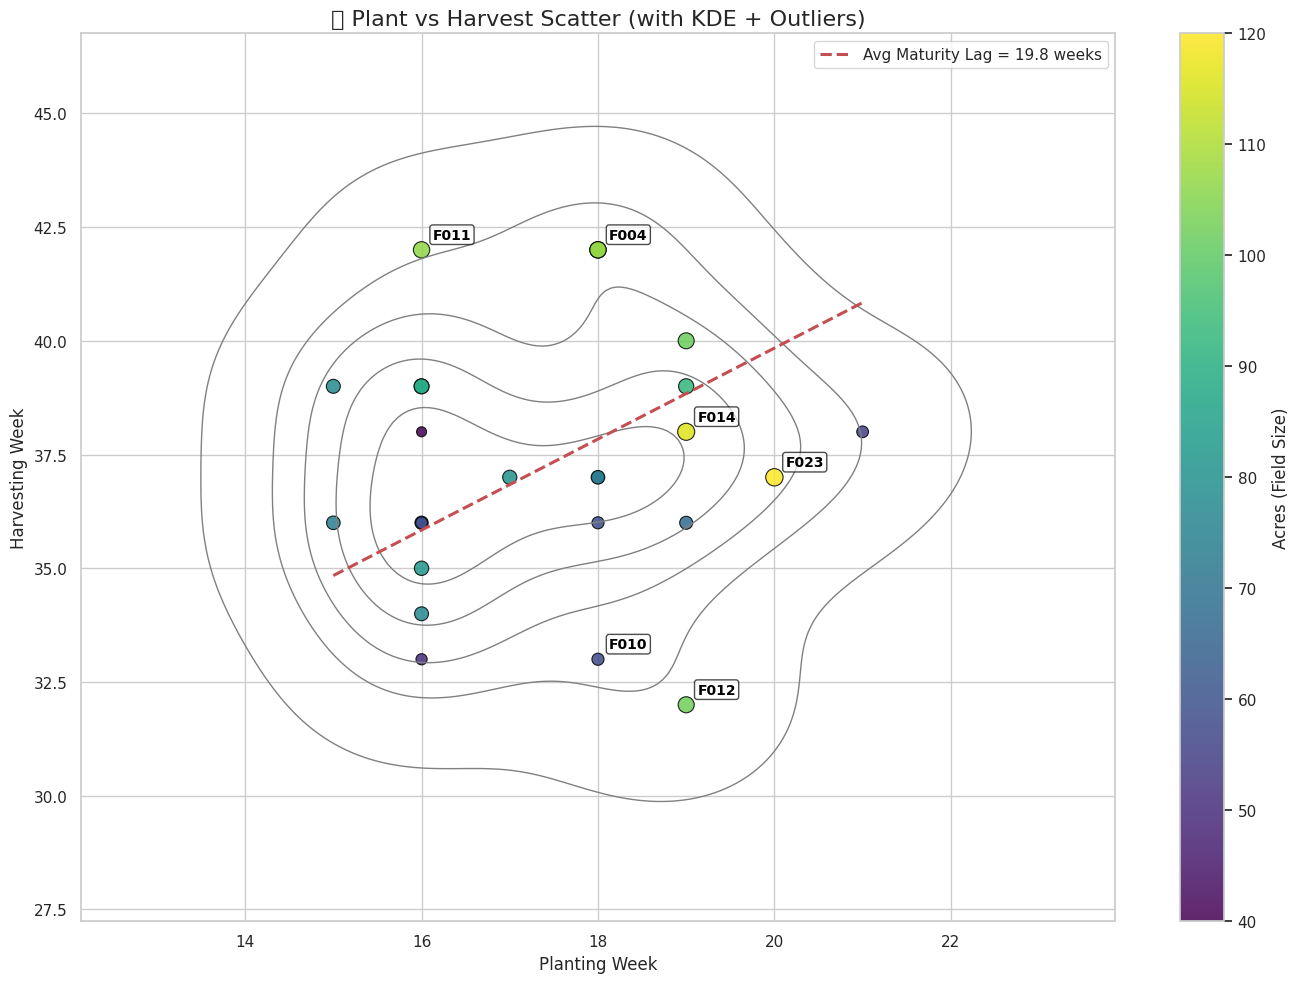

/tmp/ipykernel_46603/2908257182.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


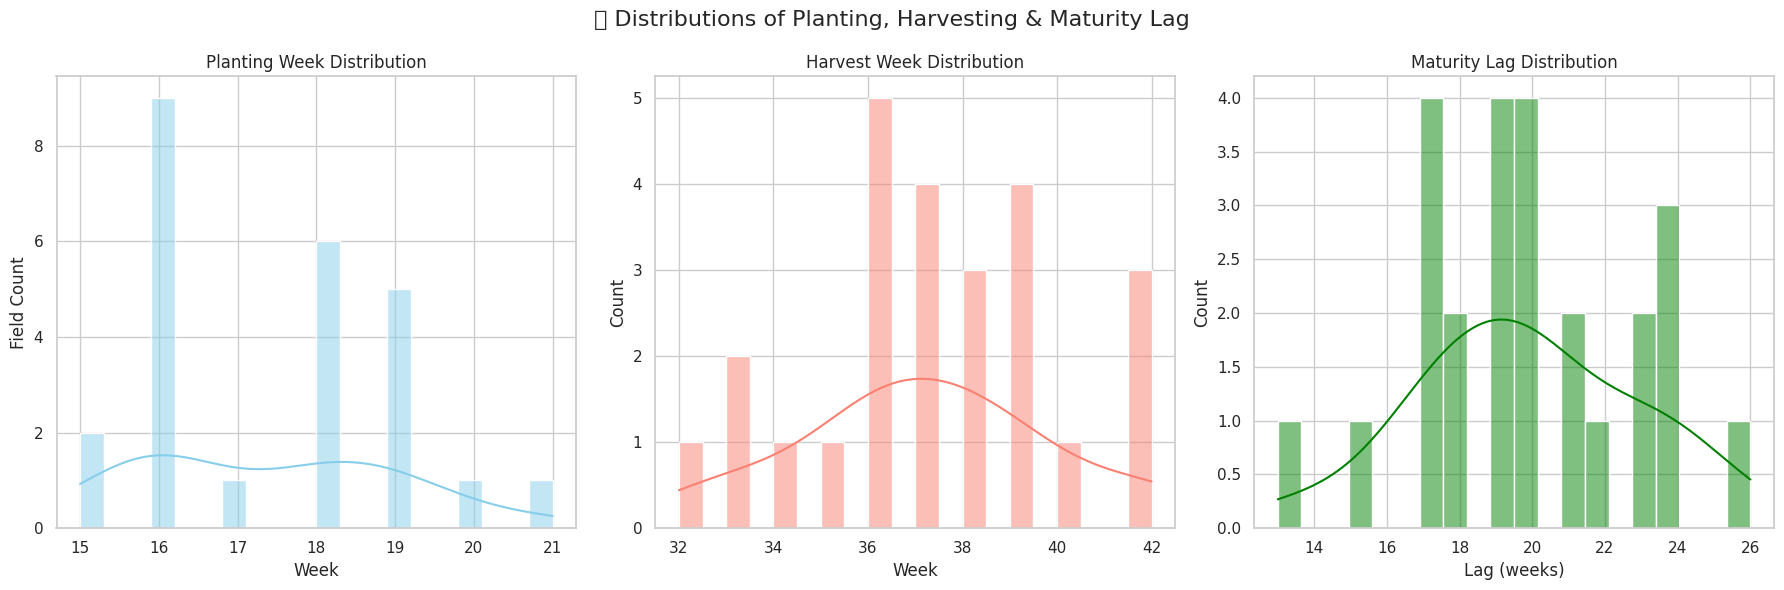

/tmp/ipykernel_46603/2908257182.py:130: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


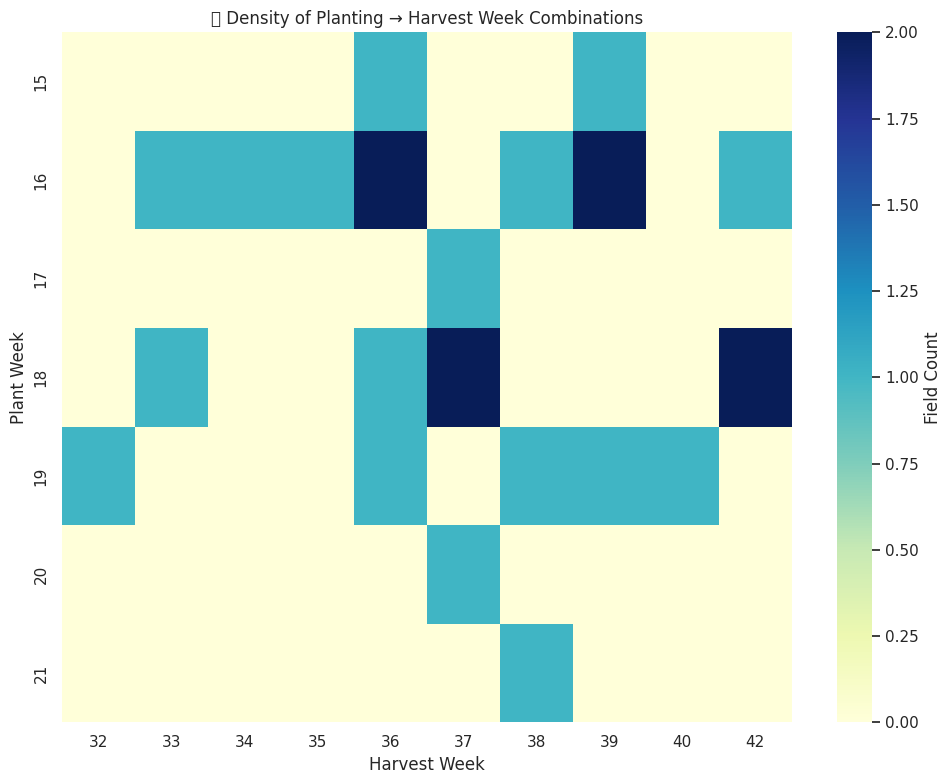

,field_id,plant_week,harvest_week,early_penalty,late_penalty,frost_penalty,total_penalty,status,makespan,acres,maturity_lag
0,F001,16,39,0.0,0.0,0.0,0.0,OK,42.0,87.227749,23
1,F002,21,38,0.0,0.0,0.0,0.0,OK,42.0,54.752514,17
2,F003,19,40,0.0,0.0,0.0,0.0,OK,42.0,101.833288,21
3,F004,18,42,0.0,0.0,0.0,0.0,OK,42.0,108.790255,24
4,F005,16,38,0.0,0.0,0.0,0.0,OK,42.0,40.000000,22
5,F006,16,33,0.0,0.0,0.0,0.0,OK,42.0,50.014717,17
6,F007,16,35,0.0,0.0,0.0,0.0,OK,42.0,82.034705,19
7,F008,16,36,0.0,0.0,0.0,0.0,OK,42.0,70.329222,20
8,F009,15,39,0.0,0.0,0.0,0.0,OK,42.0,78.020629,24
9,F010,18,33,0.0,0.0,0.0,0.0,OK,42.0,58.406055,15


In [12]:
plot_full_maturity_suite(sched, fields)


In [17]:
def plot_milp_gantt(sched_df, fields_df, title_suffix=""):
    # merge acres
    df = sched_df.merge(fields_df[["field_id", "acres"]], on="field_id", how="left")
    df = df.sort_values("field_id")

    # index for y-axis
    df["y"] = range(len(df))

    sns.set_theme(style="whitegrid", context="talk")

    fig, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)
    plt.subplots_adjust(wspace=0.18)

    # -------------------------------------------------------
    # 1️⃣ Planting Gantt Chart
    # -------------------------------------------------------
    ax = axes[0]

    for _, row in df.iterrows():
        ax.barh(
            row["y"],
            width=0.9,
            left=row["plant_week"],
            color=sns.color_palette("Greens", 10)[4],
            alpha=0.85
        )

    ax.set_title(f"🌱 Planting Gantt Chart {title_suffix}")
    ax.set_xlabel("Week")
    ax.set_ylabel("Field")
    ax.set_yticks(df["y"])
    ax.set_yticklabels(df["field_id"])
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    # -------------------------------------------------------
    # 2️⃣ Harvest Gantt Chart
    # -------------------------------------------------------
    ax = axes[1]

    for _, row in df.iterrows():
        ax.barh(
            row["y"],
            width=0.9,
            left=row["harvest_week"],
            color=sns.color_palette("Oranges", 10)[6],
            alpha=0.85
        )

    ax.set_title(f"🌽 Harvesting Gantt Chart {title_suffix}")
    ax.set_xlabel("Week")
    ax.set_yticks(df["y"])
    ax.set_yticklabels(df["field_id"])
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_46603/3051984313.py:57: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46603/3051984313.py:57: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


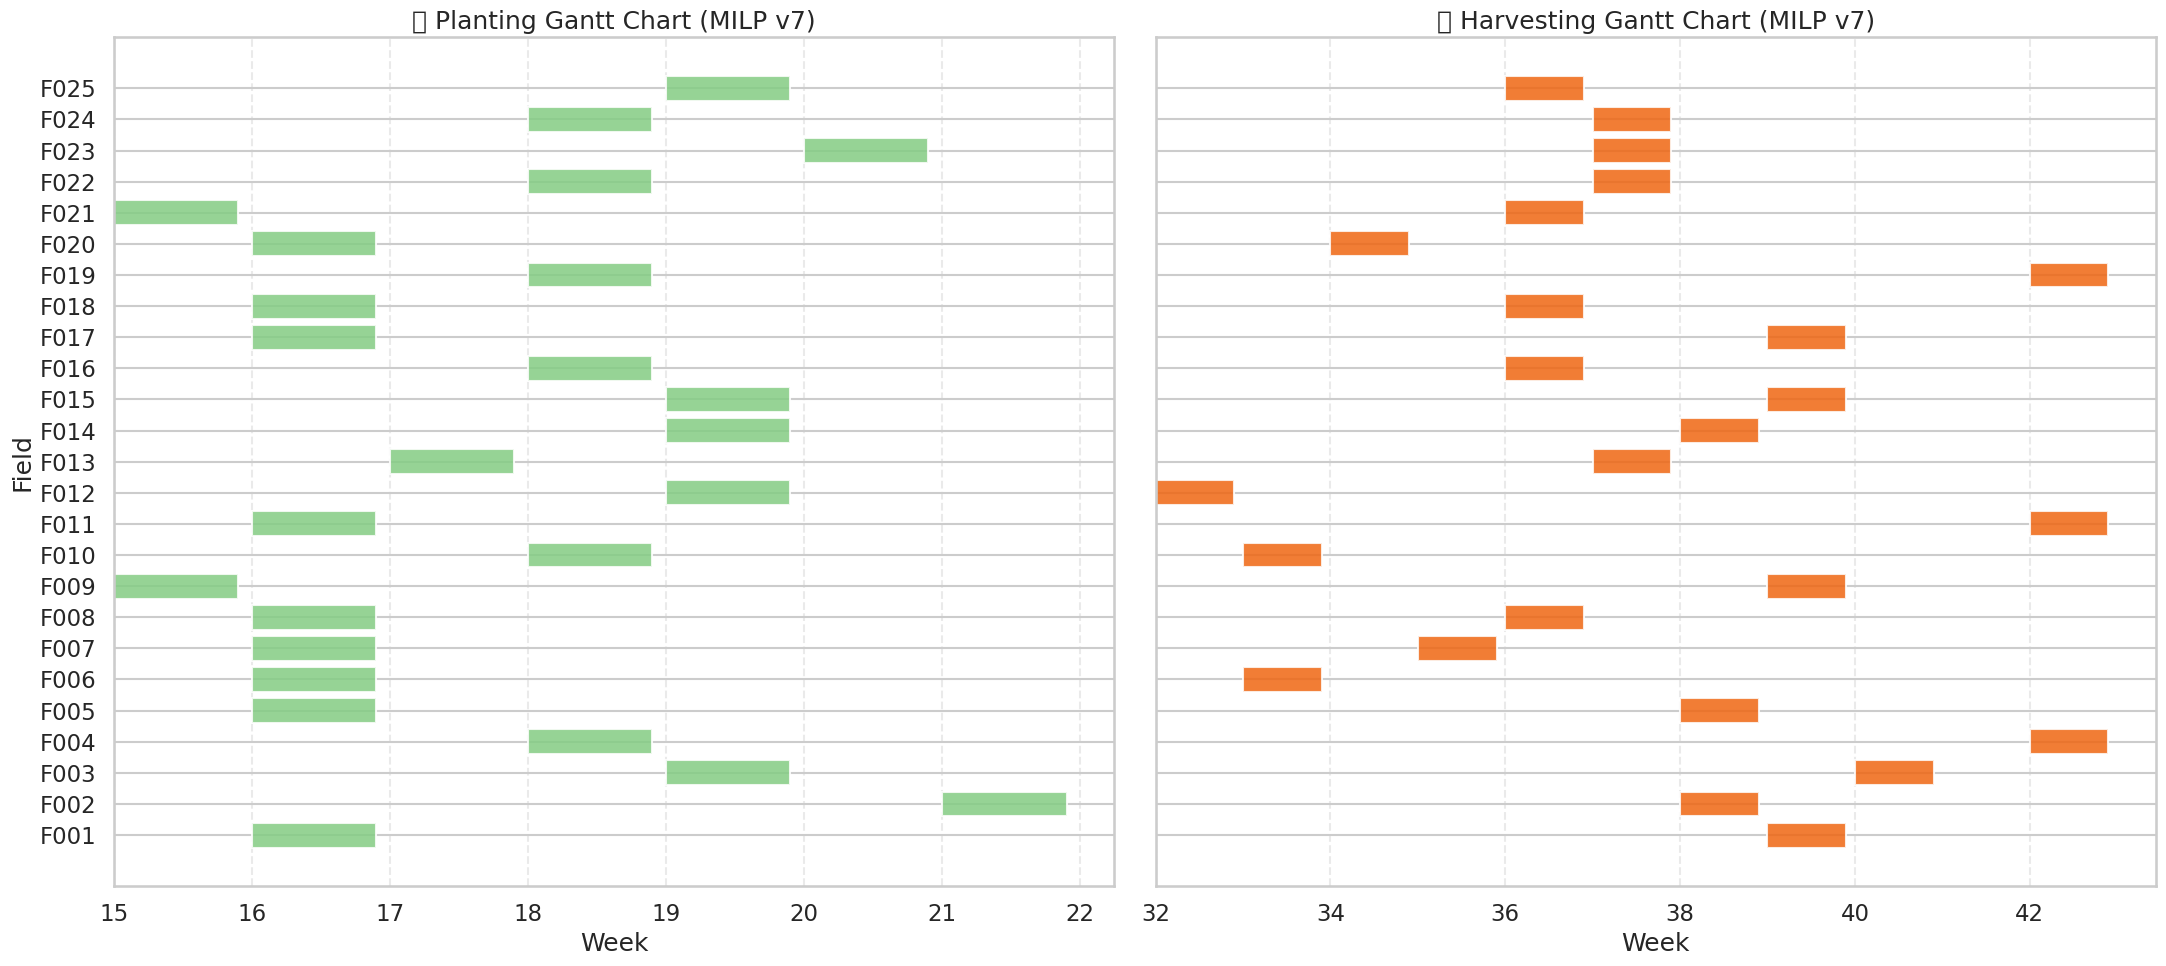

In [18]:
sched = pd.read_csv("../../data/processed/schedule_outputv7.csv")
fields = pd.read_csv("../../data/processed/illinois_corn_fields_clean.csv")

plot_milp_gantt(sched, fields, title_suffix="(MILP v7)")
